In [390]:
import numpy as np
import pandas as pd


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Present Value of Liabilities and Funding Ratio


The funding ratio is the ratio of the current value of assets divided to the present value of the liabilities.

In order to compute the present value, we need to discount the amount of the liability based on the relevant interest rate derived from the yield curve.


The present value of a set of liabilities $L$ where each liability $L_i$ is due at time $t_i$ is give by:

$$ PV(L) = \sum_{i=1}^{k} B(t_i) L_i$$

where $B(t_i)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$

If we assume the yield curve is flat and the annual rate of interest is $r$ then $B(t)$ is given by

$$B(t) = \frac{1}{(1+r)^t}$$

In [391]:
def discount(t, r):
    """
    Compute the price of a discount bond that pays $1 at time t where t is in years and r is the annual interest rate
    """
    return (1+r)**(-t)

In [392]:
def pv(l, r):
    """
    Compute the present value of a list of liabilities given by the time (as an index) and amounts
    """
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

Lets assumes three liabilities, for the three category type of compensation /114, 307, 248 mln USD/ with roughly the same time to maturity 17,18,19 years. The long-term interest rate is considered by 7%

In [393]:
liabilities = pd.Series(data=[114000000,307000000,248000000], index=[18.4,18.5,18.6])

In [395]:
pv(liabilities, 0.08)

160850943.99446842

In [396]:
def funding_ratio(assets, liabilities, r):
    return assets/pv(liabilities, r)

Compute the funding ratio, showing how much we are underfunded or overfunded with the current assets to meet the future liability in terms of PV. The results show that with the current assets we cannot meet our long-term liability with the given interest rate and no additional financing.

In [397]:
funding_ratio(96000000, liabilities, 0.07)

0.5023756418164584

Calculator of funding ratio, the nearly 200 mln USD of current assets will be enough to cover current liabilities(annuities), in case the avg interest rate will not change

In [398]:
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print(f'{fr*100:.2f}%')
    
controls = widgets.interactive(show_funding_ratio,
                                   assets=widgets.IntSlider(min=20000000, max=300000000, step=1, value=95.8),
                                   r=(0, .20, .01)
)
display(controls)

interactive(children=(IntSlider(value=20000000, description='assets', max=300000000, min=20000000), FloatSlide…

# CIR model

To simulate changes in interest rates and liability hedging strategy

We're going to simulate changes in interest rates using the Cox-Ingersoll-Ross model, usually just called the CIR model.

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$
 
where  𝑎  is the speed of mean reversion and  𝑏  is the long term mean rate and  𝜎  is the volatility parameter.

This can be read as describing the change in interest at any point of time as a multiple of the distance of the current rate from it's long term mean plus a random value that depends on the volatility parameter.

Thus, we can start at some rate  𝑟0  and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the  𝑟𝑡⎯⎯⎯√  term we get the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero.

In [315]:
"""
    Convert an instantaneous interest rate to an annual interest rate
    """
def inst_to_ann(r):
  
    return np.expm1(r)

def ann_to_inst(r):

    return np.log1p(r)


Interest rate change over time: CIR model. changes in the interest rates is defined by the difference from the mean of interest rate today: a is the speed of mean reversion; the second expression of the CIR model is the shock parameter

In [399]:
def cir(n_years = 20, n_scenarios=1, a=0.03, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rates
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t) 
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

%matplotlib inline

Show the chart of calculated interest rates

<AxesSubplot:>

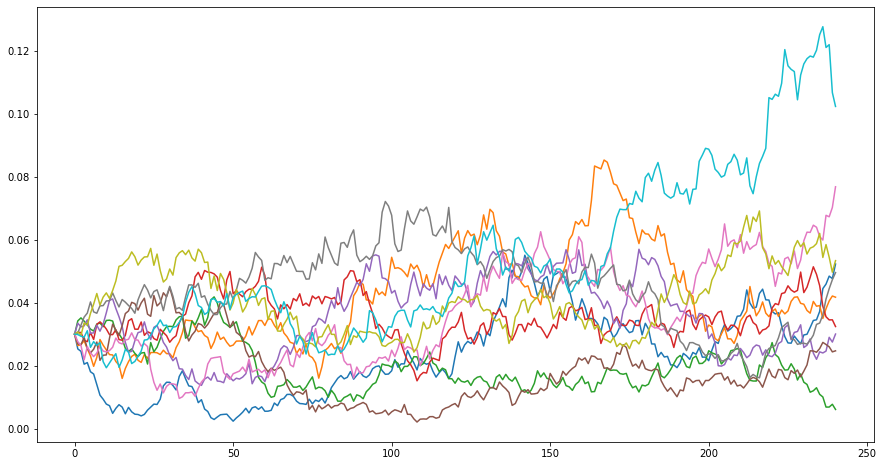

In [404]:
cir(n_scenarios=10).plot(legend=False, figsize=(15,8))

# add price generation function to the CIR model

In [437]:
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

In [438]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 1000))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

add zero coupon bonds to the model

In [475]:
# cash in hand 
a_0 = 7500000
# simulate the next 10 years
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = pv(pd.Series(data=[100], index=[10]), 0.05)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest
av_cash = a_0*(rates/12+1).cumprod()

<AxesSubplot:title={'center':'Asset Values using Cash (10 scenarios)'}>

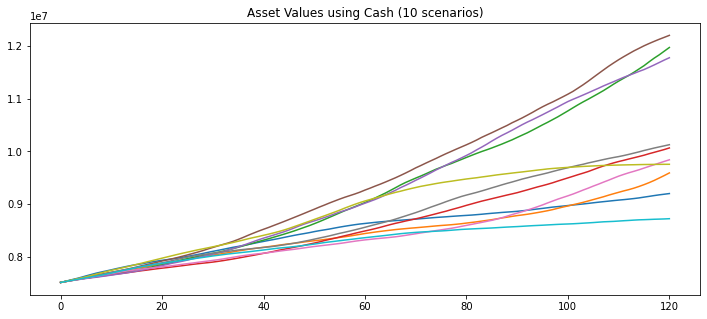

In [476]:
av_cash.plot(title='Asset Values using Cash (10 scenarios)', legend=False, figsize=(12,5))

<AxesSubplot:title={'center':'Asset Values using ZC Bonds (10 scenarios)'}>

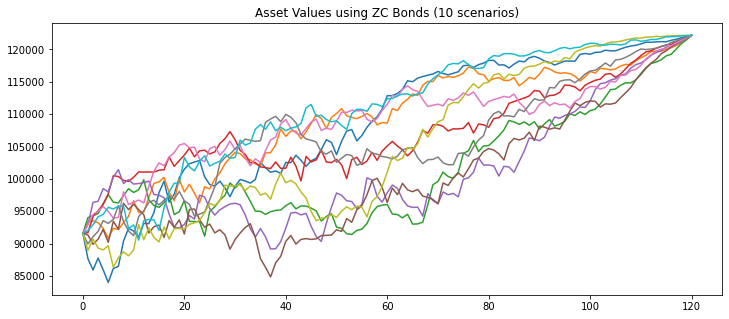

In [477]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

<AxesSubplot:title={'center':'Returns of Funding Ratio with Cash (10 scenarios)'}>

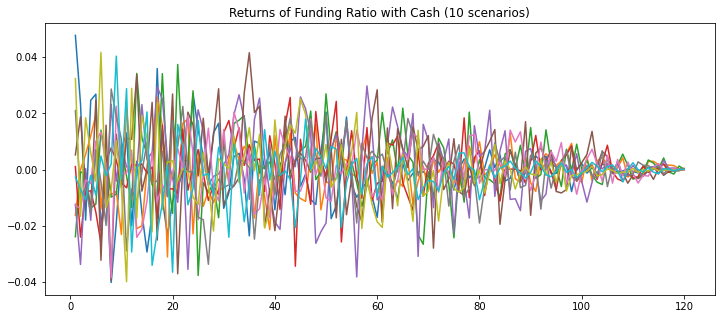

In [478]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

<AxesSubplot:title={'center':'Returns of Funding Ratio with ZC Bonds (10 scenarios)'}>

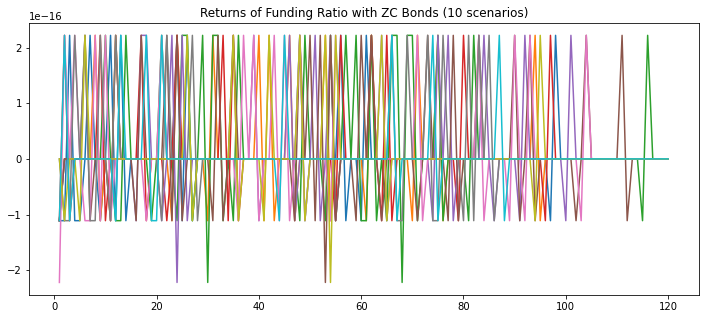

In [480]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

In [473]:
a_0= 0.5
rates,bond_prices=cir(n_scenarios=1000,r_0=0.07,b=0.07)
liabilities=bond_prices
zc_0=pv(pd.Series(data=[670], index=[20]), 0.07)
n_bonds=a_0/zc_0
av_zc_bonds=n_bonds+bond_prices
av_cash=a_0*(rates/12+1).cumprod()

<AxesSubplot:>

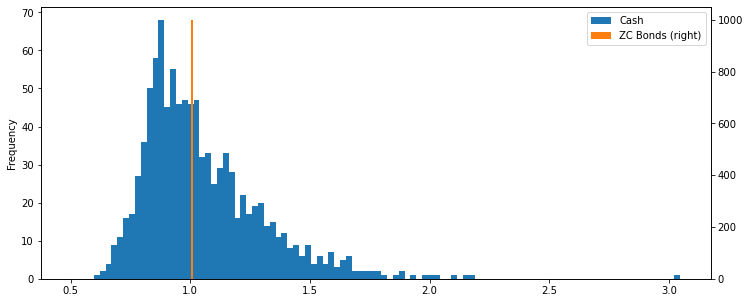

In [474]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(12,5), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax,label="ZC Bonds", bins=100, secondary_y=True, legend=True)

### Conclusion

As you can see, hedging a future liability with cash or even cash-like instruments can be very risky. Although Zero Coupon Bonds are nominally risky and can see a great deal of price fluctuation, they vary in price in tandem with the liabilities, resulting in a much better hedge.

Of course, this makes two convenient assumptions that are often not true in practice. First, it assumes that zero coupon bonds with the perfect maturities are always available, and second, it assumes that you have the intial assets to be able to afford the hedge.


Case with regular coupon bonds

In [327]:
import math
def bond_cash_flows(maturity, principal=100, coupon_rate=0.07, coupons_per_year=12):
    """
    Returns the series of cash flows generated by a bond,
    indexed by the payment/coupon number
    """
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year
    coupon_times = np.arange(1, n_coupons+1)
    cash_flows = pd.Series(data=coupon_amt, index=coupon_times)
    cash_flows.iloc[-1] += principal # add the principal to the last payment
    return cash_flows

In [328]:
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.07):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return pv(cash_flows, discount_rate/coupons_per_year)

In [329]:
bond_price(20,96,0.10,1,0.08)

114.85084302230257

Bond prices with the changing interest rates

<AxesSubplot:title={'center':'Change in 10Y Bond Prices with Interest Rates'}>

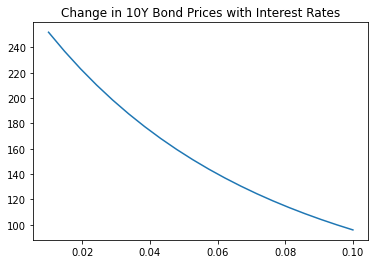

In [330]:
rates = np.linspace(.01, .10, num=20)
prices = [bond_price(20, 96, 0.10, 1, rate) for rate in rates]
pd.DataFrame(data=prices, index=rates).plot(title="Change in 10Y Bond Prices with Interest Rates", legend=False)

In [331]:
cf = bond_cash_flows(20, 96, 0.1, 1)
cf

1       9.6
2       9.6
3       9.6
4       9.6
5       9.6
6       9.6
7       9.6
8       9.6
9       9.6
10      9.6
11      9.6
12      9.6
13      9.6
14      9.6
15      9.6
16      9.6
17      9.6
18      9.6
19      9.6
20    105.6
dtype: float64

In [332]:
discounts = discount(cf.index, 0.1)
discounts

Float64Index([ 0.9090909090909091,  0.8264462809917354,  0.7513148009015775,
               0.6830134553650705,  0.6209213230591549,  0.5644739300537771,
               0.5131581182307065,  0.4665073802097331,  0.4240976183724846,
               0.3855432894295314,  0.3504938994813922,  0.3186308177103565,
               0.2896643797366877, 0.26333125430607973, 0.23939204936916336,
               0.2176291357901485, 0.19784466890013497,  0.1798587899092136,
              0.16350799082655781, 0.14864362802414344],
             dtype='float64')

In [333]:
dcf = (discounts*cf)
dcf

1      8.727273
2      7.933884
3      7.212622
4      6.556929
5      5.960845
6      5.418950
7      4.926318
8      4.478471
9      4.071337
10     3.701216
11     3.364741
12     3.058856
13     2.780778
14     2.527980
15     2.298164
16     2.089240
17     1.899309
18     1.726644
19     1.569677
20    15.696767
dtype: float64

In [334]:
(cf.index*dcf).sum()/dcf.sum()

9.364920091734417

This is the Macaulay Duration which is the weighted average number of periods you have to be invested in the bond to get the present value of the bond back. In this example, we'll need to wait about 9.4 years on average to get back the present value of the bond.

In [335]:
def macaulay_duration(flows, discount_rate):
    """
    Computes the Macaulay Duration of a sequence of cash flows, given a per-period discount rate
    """
    discounted_flows = discount(flows.index, discount_rate)*flows
    weights = discounted_flows/discounted_flows.sum()
    return np.average(flows.index, weights=weights)

In [336]:
macaulay_duration(bond_cash_flows(1.5,96000000, 0.1, 1), 0.1)

1.909090909090909

MD for Liabilities

In [337]:
liabilities= pd.Series(data=[114000000,307000000,248000000],index=[17,18,19])
macaulay_duration(liabilities,0.1)

18.152092200541706

In [338]:
md_1_5=macaulay_duration(bond_cash_flows(1.5,1000,0.1,1),0.1)
md_5=macaulay_duration(bond_cash_flows(5,1000,0.1,1),0.1)

In [339]:
md_1_5,md_5

(1.909090909090909, 4.169865446349293)

Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times  + (1-w_s) \times  = 18.15 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

In [340]:
short_bond=bond_cash_flows(1.5,1000,0.10,1)
long_bond=bond_cash_flows(15,1000,0.105,1)
w_s=match_durations(liabilities,short_bond,long_bond,0.08)
w_s

-1.3666608940773937

MD for assets

In [341]:
p_short=bond_price(1.5,1000,0.10,1,0.1)
p_long=bond_price(15,1000,0.105,1,0.1)
a_0=96000000
p_flows=pd.concat([a_0*w_s*short_bond/p_short,a_0*(1-w_s)*long_bond/p_short])
macaulay_duration(p_flows,0.1)

16.290904159527148

Duration matching for funding ratio

In [342]:
def funding_ratio(assets, liabilities, r):
    return pv(assets,r)/pv(liabilities, r)

In [343]:
current_fr=funding_ratio(p_flows,liabilities,0.10)
current_fr

0.8843785448010892

In [344]:
import matplotlib

<AxesSubplot:title={'center':'Funding ratio with changes in % rates'}>

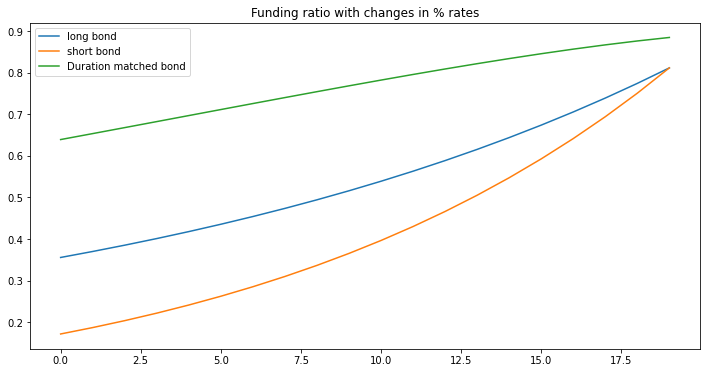

In [345]:
%matplotlib inline
rates=np.linspace(0,.1,20)
lb_assets=a_0*long_bond/p_long
sb_assets=a_0*short_bond/p_short

fr_change=pd.DataFrame({
    "long bond":(funding_ratio(lb_assets,liabilities,r) for r in rates),
    "short bond":(funding_ratio(sb_assets,liabilities,r) for r in rates),
    "Duration matched bond":(funding_ratio(p_flows,liabilities,r) for r in rates)
})

fr_change.plot(title="Funding ratio with changes in % rates",figsize=(12,6))

Simulation of prices of Coupon-Bearing bonds with CIR

In [346]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at time period t
    and r is the per-period interest rate
    returns a |t| x |r| Series or DataFrame
    r can be a float, Series or DataFrame
    returns a DataFrame indexed by t
    """
    discounts = pd.DataFrame([(r+1)**-i for i in t])
    discounts.index = t
    return discounts

In [347]:
def pv(flows, r):
    """
    Compute the present value of a sequence of cash flows given by the time (as an index) and amounts
    r can be a scalar, or a Series or DataFrame with the number of rows matching the num of rows in flows
    """
    dates = flows.index
    discounts = discount(dates, r)
    return discounts.multiply(flows, axis='rows').sum()

In [348]:
bond_price(5,100,0.05,12,0.03)

0    109.275393
dtype: float64

In [349]:
rates,zc_prices=cir(10,500,b=0.03,r_0=0.03)

In [353]:
bond_price(5,100,0.05,12,rates.iloc[1][[1,2,3]])

1    108.412959
2    109.310163
3    109.107798
dtype: float64

In [358]:
rates[[1,2,3]].head()

,1,2,3
0,0.030000,0.030000,0.030000
1,0.031780,0.029929,0.030345
2,0.031746,0.030827,0.030472
3,0.024866,0.030127,0.030248
4,0.028939,0.029076,0.033120


In [359]:
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    If discount_rate is a DataFrame, then this is assumed to be the rate on each coupon date
    and the bond value is computed over time.
    i.e. The index of the discount_rate DataFrame is assumed to be the coupon number
    """
    if isinstance(discount_rate, pd.DataFrame):
        pricing_dates = discount_rate.index
        prices = pd.DataFrame(index=pricing_dates, columns=discount_rate.columns)
        for t in pricing_dates:
            prices.loc[t] = bond_price(maturity-t/coupons_per_year, principal, coupon_rate, coupons_per_year,
                                      discount_rate.loc[t])
        return prices
    else: # base case ... single time period
        if maturity <= 0: return principal+principal*coupon_rate/coupons_per_year
        cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
        return pv(cash_flows, discount_rate/coupons_per_year)

<AxesSubplot:>

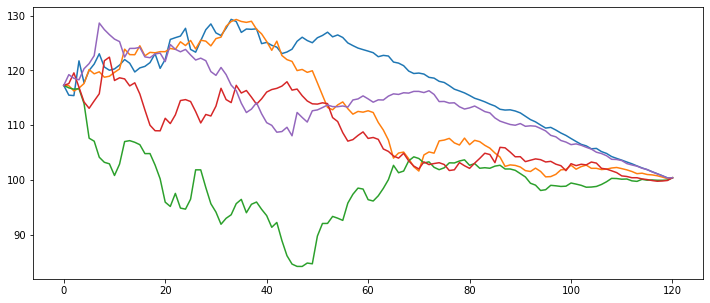

In [361]:
bond_price(10,100,0.05,12,rates[[1,2,3,4,5]]).plot(legend=False,figsize=(12,5))

In [362]:
prices=bond_price(10,100,0.05,12,rates[[1,2,3,4,5]])
prices

,1,2,3,4,5
0,117.260292,117.260292,117.260292,117.260292,117.260292
1,115.480874,117.203804,116.813985,117.593226,119.228706
2,115.400602,116.246386,116.57464,119.550054,118.555879
3,121.741027,116.772028,116.659853,116.919756,118.286868
4,117.740567,117.613883,113.946747,114.237427,120.308951
...,...,...,...,...,...
116,101.507049,100.930999,100.012305,99.900373,101.482606
117,101.145679,100.77423,99.953074,99.773483,101.125575
118,100.78192,100.532385,99.949001,99.819859,100.756689
119,100.394244,100.252817,99.982654,99.911694,100.371433


In [363]:
def bond_total_return(monthly_prices, principal, coupon_rate, coupons_per_year):
    """
    Computes the total return of a Bond based on monthly bond prices and coupon payments
    Assumes that dividends (coupons) are paid out at the end of the period (e.g. end of 3 months for quarterly div)
    and that dividends are reinvested in the bond
    """
    coupons = pd.DataFrame(data = 0, index=monthly_prices.index, columns=monthly_prices.columns)
    t_max = monthly_prices.index.max()
    pay_date = np.linspace(12/coupons_per_year, t_max, int(coupons_per_year*t_max/12), dtype=int)
    coupons.iloc[pay_date] = principal*coupon_rate/coupons_per_year
    total_returns = (monthly_prices + coupons)/monthly_prices.shift()-1
    return total_returns.dropna()


In [365]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

In [366]:
p=bond_price(10,100,.05,12,rates[[1,2,3,4]])
btr=bond_total_return(p,100,.05,12)
annualize_rets(btr,12)

1    0.027475
2    0.029599
3    0.035564
4    0.031094
dtype: object

In [368]:
price_10=bond_price(10,100,.05,12,rates)
price_10[[1,2,3,4]].tail()

,1,2,3,4
116,101.507049,100.930999,100.012305,99.900373
117,101.145679,100.77423,99.953074,99.773483
118,100.78192,100.532385,99.949001,99.819859
119,100.394244,100.252817,99.982654,99.911694
120,100.416667,100.416667,100.416667,100.416667


In [369]:
price_30=bond_price(30,100,.05,12,rates)
price_30[[1,2,3,4]].tail()

,1,2,3,4
116,187.705592,145.989712,100.477018,96.244401
117,189.062152,152.221201,97.630125,89.213998
118,191.769799,154.117255,96.191294,87.369019
119,192.511652,150.409955,97.399761,87.650184
120,188.636474,148.434867,96.303288,83.261412


In [371]:
rets_30=bond_total_return(price_30,100,.05,12)
rets_10=bond_total_return(price_10,100,.05,12)
rets_bonds=0.60*rets_10+0.40*rets_30

In [383]:
mean_rets_bonds=rets_bonds.mean(axis='columns')
summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.03598,0.003643,-0.227835,3.359806,-0.001169,-0.000595,1.597875,-0.00022


In [381]:
def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

In [380]:
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

                         
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))


C:\python\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [384]:
mean_rets_bonds=rets_bonds.mean(axis='columns')
summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.03598,0.003643,-0.227835,3.359806,-0.001169,-0.000595,1.597875,-0.00022


In [385]:
def gbm(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0, prices=True):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices through Monte Carlo
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year) + 1
    # the standard way ...
    # rets_plus_1 = np.random.normal(loc=mu*dt+1, scale=sigma*np.sqrt(dt), size=(n_steps, n_scenarios))
    # without discretization error ...
    rets_plus_1 = np.random.normal(loc=(1+mu)**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1
    ret_val = s_0*pd.DataFrame(rets_plus_1).cumprod() if prices else rets_plus_1-1
    return ret_val

In [386]:
price_eq=gbm(n_years=10,n_scenarios=500,mu=0.07,sigma=0.15)
price_eq.shape

(121, 500)

In [387]:
rets_eq=price_eq.pct_change().dropna()
rets_eq.shape

(120, 500)

In [388]:
rets=0.7*rets_eq+0.3*rets_bonds
rets_mean=rets.mean(axis='columns')
summary_stats(pd.DataFrame(rets_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.058457,0.004908,0.013763,2.623329,-0.00242,-0.00206,5.642793,0.0
